#WCGAN with RF as classifier

## Importing Libraries

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [ ]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

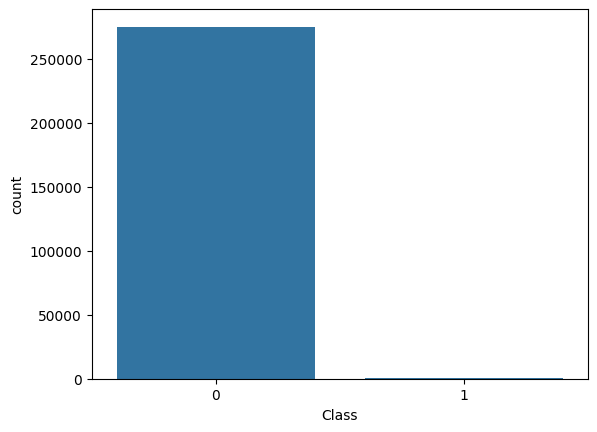

In [ ]:
sns.countplot(data=df,x='Class')

In [ ]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


<Axes: xlabel='Amount', ylabel='Density'>

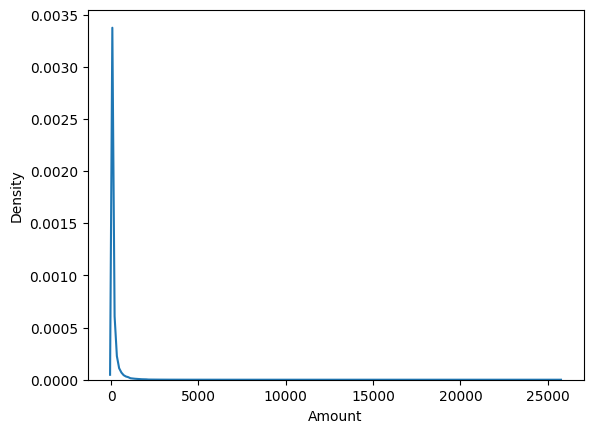

In [ ]:
sns.kdeplot(df['Amount'])

<Axes: xlabel='Amount', ylabel='Density'>

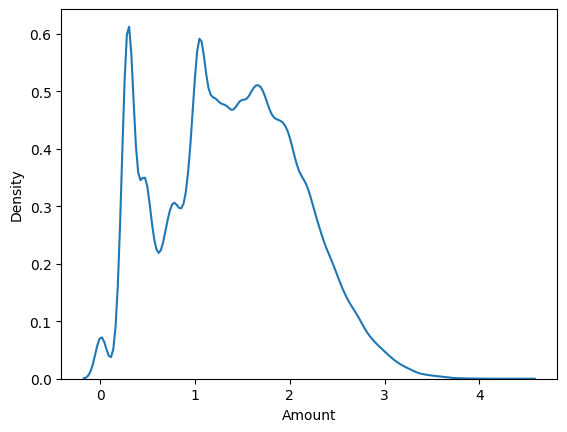

In [ ]:
df['Amount'] = df['Amount'].apply(lambda x: np.log10(x+1))
sns.kdeplot(df['Amount'])

## Creating a sub sample

What - create a[](http://) df with equal number of fraud and non fraud samples  
Why - Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the target. By having an imbalance dataframe we are not able to see the true correlations between the class and features

In [ ]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

subsample = pd.concat([fraud_df, non_fraud_df])
new_df = subsample.sample(frac=1, random_state=42)

### Correlation

In [ ]:
corr = df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

In [ ]:
corr = new_df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

Negative Correlations: V17, V14, V12 and V10 are negatively correlated.
Positive Correlations: V2, V4, V11 are positively correlated.

Note-Used chatgpt to understand the correlations. As the features are anonymised it was difficult to conclude and get relationship and dependency on eachother.

Negative Correlations: V17, V14, V12 and V10 are negatively correlated.  
Positive Correlations: V2, V4, V11 are positively correlated.

In [ ]:
# Calculate absolute correlation matrix (optional: choose df or new_df)
corr_matrix = new_df.corr().abs()

# Select upper triangle of correlation matrix to avoid duplicates and self-correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Set threshold
threshold = 0.9

# Find feature pairs with high correlation
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in upper.columns
                   for col2 in upper.columns
                   if (upper.loc[col1, col2] > threshold)]

# Display results
print("Highly Correlated Feature Pairs (|r| > 0.9):")
for f1, f2, corr_value in high_corr_pairs:
    print(f"{f1} ↔ {f2}: r = {corr_value:.2f}")

Highly Correlated Feature Pairs (|r| > 0.9):
V16 ↔ V17: r = 0.95
V17 ↔ V18: r = 0.94


### TSNE

In [ ]:
from sklearn.manifold import TSNE
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE Implementation
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

In [ ]:
fig=px.scatter(x=X_reduced_tsne[:,0], y=X_reduced_tsne[:,1], color=y)
fig.show()

Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately

Reference- https://www.geeksforgeeks.org/machine-learning/difference-between-pca-vs-t-sne/

Note-ChatGPT was used to help understand the results using WebSearch Feature.

## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Testing baseline model with original data

# WCGAN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam

def gradient_penalty(critic, real, fake, cond, gp_weight):
    # real, fake, cond are tf.Tensors of shape (batch, dim)
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
    diff = fake - real
    interp = real + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interp)
        pred = critic([interp, cond], training=True)
    grads = gp_tape.gradient(pred, interp)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-12)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp_weight * gp

class CWGAN_GP:
    def __init__(self,
                 data_dim=29,
                 cond_dim=2,
                 latent_dim=100,
                 gp_weight=10.0,
                 n_critic=5,
                 batch_size=64):
        self.data_dim   = data_dim
        self.cond_dim   = cond_dim
        self.latent_dim = latent_dim
        self.gp_weight  = gp_weight
        self.n_critic   = n_critic
        self.batch_size = batch_size

        self._build_generator()
        self._build_critic()
        self.gen_opt  = Adam(1e-4, beta_1=0.0, beta_2=0.9)
        self.crit_opt = Adam(1e-4, beta_1=0.0, beta_2=0.9)

    def _build_generator(self):
        z = Input((self.latent_dim,), name='z')
        c = Input((self.cond_dim,), name='c')
        x = Concatenate()([z, c])
        for units in [256, 512, 512]:
            x = Dense(units)(x)
            x = LeakyReLU(0.2)(x)
            x = BatchNormalization()(x)
        out = Dense(self.data_dim, activation='linear')(x)
        self.generator = Model([z, c], out, name='generator')

    def _build_critic(self):
        x_in = Input((self.data_dim,), name='x')
        c_in = Input((self.cond_dim,), name='c')
        x = Concatenate()([x_in, c_in])
        for units in [512, 512, 256]:
            x = Dense(units)(x)
            x = LeakyReLU(0.2)(x)
        out = Dense(1)(x)
        self.critic = Model([x_in, c_in], out, name='critic')

    def train(self, real_data, real_cond, epochs=10000):
        # real_data: np.array shape (N, data_dim)
        # real_cond: tf.Tensor shape (N, cond_dim), one-hot
        N = real_data.shape[0]

        for epoch in range(epochs):
            # --- Train critic ---
            for _ in range(self.n_critic):
                # 1) Sample real batch
                idx      = np.random.randint(0, N, self.batch_size)
                real_x   = tf.convert_to_tensor(real_data[idx], dtype=tf.float32)
                cond_x   = tf.gather(real_cond, idx)

                # 2) Sample fake batch
                z_noise  = tf.random.normal((self.batch_size, self.latent_dim))
                fake_idx = np.random.randint(0, N, self.batch_size)
                cond_z   = tf.gather(real_cond, fake_idx)
                fake_x   = self.generator([z_noise, cond_z], training=True)

                # 3) Compute gradient penalty
                gp = gradient_penalty(self.critic, real_x, fake_x, cond_x, self.gp_weight)

                # 4) Critic loss: E[fake] − E[real] + GP
                with tf.GradientTape() as tape:
                    crit_real = self.critic([real_x, cond_x], training=True)
                    crit_fake = self.critic([fake_x, cond_z], training=True)
                    loss_crit = tf.reduce_mean(crit_fake) - tf.reduce_mean(crit_real) + gp
                grads = tape.gradient(loss_crit, self.critic.trainable_variables)
                self.crit_opt.apply_gradients(zip(grads, self.critic.trainable_variables))

            # --- Train generator ---
            z_noise  = tf.random.normal((self.batch_size, self.latent_dim))
            fake_idx = np.random.randint(0, N, self.batch_size)
            cond_z   = tf.gather(real_cond, fake_idx)
            with tf.GradientTape() as tape:
                fake_x   = self.generator([z_noise, cond_z], training=True)
                crit_fake= self.critic([fake_x, cond_z], training=True)
                loss_gen = -tf.reduce_mean(crit_fake)
            grads = tape.gradient(loss_gen, self.generator.trainable_variables)
            self.gen_opt.apply_gradients(zip(grads, self.generator.trainable_variables))

            if epoch % 100 == 0:
                print(f"Epoch {epoch:5d} | Critic loss: {loss_crit:.4f} | Gen loss: {loss_gen:.4f}")


In [ ]:
# 1) Instantiate
cwgan_gp = CWGAN_GP(
    data_dim   = X_train.shape[1],
    cond_dim   = 2,                # e.g. [fraud, non-fraud]
    latent_dim = 100,
    gp_weight  = 10.0,
    n_critic   = 5,
    batch_size = 64
)

# 2) One-hot encode your labels
y_flat    = tf.reshape(y_train, [-1])              # (N,)
y_one_hot = tf.one_hot(tf.cast(y_flat, tf.int32), 2)  # shape (N,2)

# 3) Train
cwgan_gp.train(X_train, y_one_hot, epochs=1000)


Epoch     0 | Critic loss: 6.1090 | Gen loss: 0.5685
Epoch   100 | Critic loss: 1397.5780 | Gen loss: 9.2581
Epoch   200 | Critic loss: 192012.7812 | Gen loss: 70.1896
Epoch   300 | Critic loss: 6241431.0000 | Gen loss: 252.6554
Epoch   400 | Critic loss: 62133612.0000 | Gen loss: 699.1234
Epoch   500 | Critic loss: 438016192.0000 | Gen loss: 1655.2098
Epoch   600 | Critic loss: 1936973056.0000 | Gen loss: 3388.1790
Epoch   700 | Critic loss: 7145311232.0000 | Gen loss: 5287.6743
Epoch   800 | Critic loss: 17574144000.0000 | Gen loss: 9920.8896
Epoch   900 | Critic loss: 44732395520.0000 | Gen loss: 15000.6953


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# — assume you’ve already:
#    • loaded df = pd.read_csv("creditcard.csv")
#    • split & scaled: X_train, X_test, y_train, y_test
#    • instantiated & trained your CWGAN_GP as `cwgan_gp`

# 0) sanity check: you have a cwgan_gp with latent_dim
print("Latent dim:", cwgan_gp.latent_dim)

# 1) Sample noise for only-fraud synthetic data
n_synth = 250_000
noise = np.random.normal(0, 1, size=(n_synth, cwgan_gp.latent_dim)).astype(np.float32)

# 2) Build a fraud condition vector [1,0] repeated
#    (your cond_dim was 2: [fraud, non-fraud])
c_fake = np.tile(np.array([[1, 0]], dtype=np.float32), (n_synth, 1))

# 3) Generate synthetic samples
gen_samples = cwgan_gp.generator.predict([noise, c_fake], verbose=0)
print("Raw synthetic shape:", gen_samples.shape)

# 4) Invert your scaler to get back to original feature space
#    (assuming you used StandardScaler to scale X_train→X_scaled)
scaler = StandardScaler().fit(df.drop("Class", axis=1).values)
gen_orig = scaler.inverse_transform(gen_samples)
print("Inverted synthetic shape:", gen_orig.shape)

# 5) (Optional) Inspect as DataFrame
gen_df = pd.DataFrame(gen_orig, columns=df.drop("Class", axis=1).columns)
print(gen_df.head())

# 6) Append synthetic to real training set
#    Note: X_train was scaled; if you want to train a classifier on scaled data,
#    stack `gen_samples` directly instead of `gen_orig`.
gen_X_train = np.vstack([X_train, gen_samples])
print("Augmented X shape:", gen_X_train.shape)

# 7) Create corresponding labels (all 1s for fraud) and append
#    y_train should be shape (n_samples,) or (n_samples,1)
y_train_col = y_train.reshape(-1,1) if y_train.ndim == 1 else y_train
gen_y = np.ones((n_synth,1), dtype='int32')
gen_y_train = np.vstack([y_train_col, gen_y])
print("Augmented y shape:", gen_y_train.shape)


Latent dim: 100


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Raw synthetic shape: (250000, 29)
Inverted synthetic shape: (250000, 29)
         V1        V2        V3        V4        V5        V6        V7  \
0 -0.253715  0.171205 -0.904867 -0.617750 -0.257462 -0.060043  0.148036   
1  1.161654 -0.722195  1.134040  0.657625 -1.935358 -0.142218 -1.115209   
2 -0.489882 -0.567270  1.032928  0.149828 -0.343240 -0.454798 -0.174313   
3 -0.505557  1.023301  0.411002 -0.220463  0.855230 -0.081947  1.558898   
4 -0.484908 -0.059251  2.310823  1.175227 -0.310981 -0.567261  0.565086   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0  0.564103 -0.805281 -0.703481  ...  0.463993  0.709997  0.458090  0.445238   
1  0.296135  0.227779 -0.338042  ...  0.200486 -0.212152  0.030896  0.123221   
2  0.611664  0.413410 -1.643420  ... -0.747628 -0.330829 -0.512740  0.111497   
3 -0.430036 -0.336923 -0.470161  ...  0.297713 -0.253042 -0.518143 -0.191629   
4 -0.338656  0.412040 -0.305642  ...  0.383768 -0.326787 -0.714101  0.012599

#Training GAN

## Testing baseline model with generated data

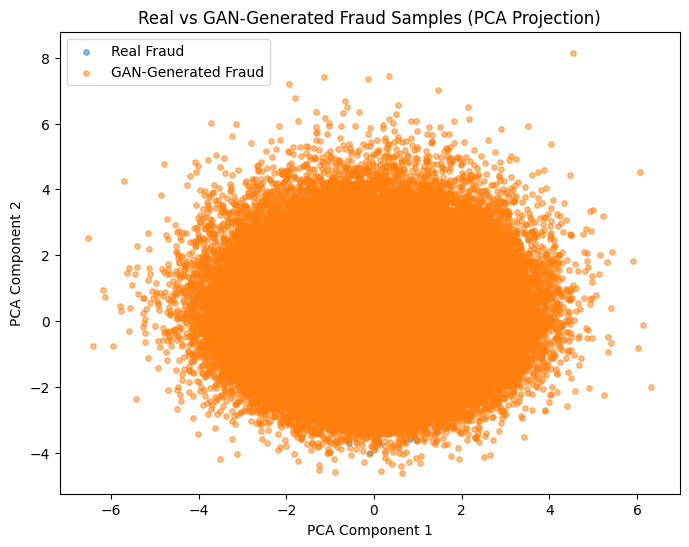

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1️⃣ Take only fraud data from real set for comparison
real_fraud = X_train[y_train.ravel() == 1]

# 2️⃣ Combine real & generated for projection
combined_data = np.vstack([real_fraud, gen_samples])
labels = np.array([0] * len(real_fraud) + [1] * len(gen_samples))  # 0=Real, 1=Generated

# 3️⃣ Apply PCA to 2 components
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(combined_data)

# 4️⃣ Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(proj[labels==0, 0], proj[labels==0, 1],
            alpha=0.5, label='Real Fraud', s=15)
plt.scatter(proj[labels==1, 0], proj[labels==1, 1],
            alpha=0.5, label='GAN-Generated Fraud', s=15)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Real vs GAN-Generated Fraud Samples (PCA Projection)")
plt.legend()
plt.show()



Note- ChatGPT used for understanding results and how discriminator can be used.

Reference-https://medium.com/the-research-nest/exploring-gans-to-generate-synthetic-data-ca48f8a4b518

Interpretation:

The WCGAN-generated fraud samples form a very dense, spherical distribution that covers a wide PCA region.

Compared to vanilla GANs, the distribution is more stable and less noisy, thanks to the Wasserstein loss with gradient penalty, which improves convergence and reduces mode collapse.

However, the generated data appear too uniformly spread—suggesting that while WCGAN maintains diversity, it may sometimes generate overly “generic” fraud points rather than perfectly mimicking the nuanced distribution of real fraud.

Conclusion:

Strengths: WCGAN produces stable and diverse synthetic fraud samples, avoiding the collapse issues seen in plain GANs.

Weaknesses: The spread suggests some loss of realism, as real fraud cases tend to cluster in more structured subspaces.

Implication for classification: This explains why WCGAN + LGBM gave balanced recall and precision—the classifier benefits from the broad coverage of synthetic fraud, even if the fine-grained structure is slightly off.

ROC-AUC: 0.9527
PR-AUC:  0.3290

Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9708    0.9850     55038
           1     0.0429    0.7579    0.0812        95

    accuracy                         0.9705     55133
   macro avg     0.5212    0.8644    0.5331     55133
weighted avg     0.9979    0.9705    0.9834     55133



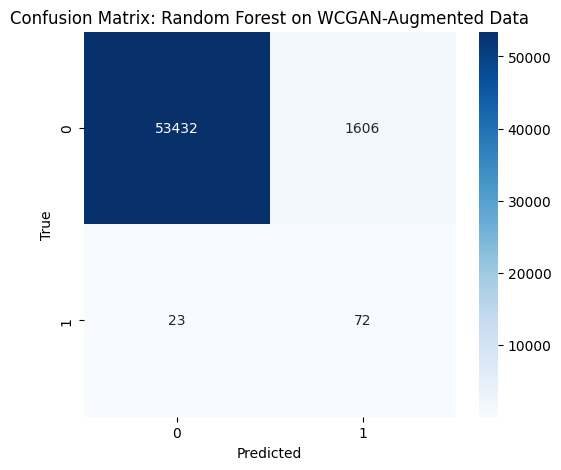

In [ ]:
# 1) Imports
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# 2) Assume you already have:
#    gen_X_train: np.ndarray or pd.DataFrame, shape (N_train, n_features)
#    gen_y_train: np.ndarray,        shape (N_train,) or (N_train,1)
#    X_test_scaled: pd.DataFrame,    shape (N_test,  n_features)
#    y_test:       np.ndarray,       shape (N_test,)
#
# If your gen_y_train is (N_train,1), flatten it:
gen_y_train = gen_y_train.ravel()

# 3) Instantiate and train RandomForest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(gen_X_train, gen_y_train)

# 4) Predict & probability scores on hold-out
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

# 5) Compute metrics
roc  = roc_auc_score(y_test, y_prob)
pr   = average_precision_score(y_test, y_prob)

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC:  {pr:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# 6) Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Random Forest on WCGAN-Augmented Data")
plt.show()

ROC-AUC: 0.9527 → Indicates strong overall discrimination ability between fraud and non-fraud.

PR-AUC: 0.3290 → Relatively low, suggesting that precision is weak when dealing with highly imbalanced data (too many false positives compared to true positives).

Fraud (Class 1):

Precision = 0.0429 → Very poor, meaning only ~4% of predicted frauds are actually fraud.

Recall = 0.7579 → High, meaning the model catches ~76% of fraud cases.

F1 = 0.0812 → Very low due to precision–recall imbalance.

Non-Fraud (Class 0):

Precision = 0.9996, Recall = 0.9708 → Excellent at classifying legitimate transactions, with very few false alarms.

Conclusion:

Strength: WCGAN + RF shows excellent recall for fraud detection (75%), making it effective when the goal is to minimize missed fraud cases (high sensitivity).

Weakness: Very low precision (4%), meaning it generates too many false alarms — problematic in real-world applications where false positives are costly.

Trade-off: This combination favors catching as many frauds as possible, even at the expense of overwhelming investigators with false alerts.

Implication: Useful in scenarios where recall is prioritized (e.g., pre-screening transactions before further checks). However, for practical deployment, this setup needs post-filtering or hybrid methods to balance precision and recall.

Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355),https://www.kaggle.com/code/shiratorizawa/wcgan, https://www.kaggle.com/code/gauravduttakiit/cc-fraud-detection-gan-random-forest-classifier/data

Note- ChatGPT used for understanding results and on error in the main wcgan model based on the gradient penalty and how it used.